## Bounding Box Generation from Class Activation Maps

In [1]:
from fastai.vision.all import *
from fastai.medical.imaging import *
from fmi.preprocessing import *
from fmi.train import *
from fmi.examine import *
import pydicom

matplotlib.rcParams['image.cmap'] = 'viridis'

This notebook uses the approach of generating bounding boxes from Class Activation Maps (CAM). CAM was introduced by Bolei Zhou et al. in the paper [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150) and is a great tool for model interpretation.

Grad CAM is a variation of CAM that was introduced in [Grad-CAM: Why Did You Say That? Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1611.07450)

Grad CAM is similar to CAM in that it is a weighted combination of feature maps but followed by a ReLU. The output of Grad CAM is a “class-discriminative localization map” where the hot part of the heatmap corresponds to a particular class. 

CAM uses the output of the last convolutional layer to provide a heatmap visualization.  A way of acccessing the activations during the training phase in Pytorch is done by using a hook. A hook is basically a function that is executed when either the forward or backward pass is called.

`Fastai` conveniently has a `Hook` class

In [2]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

The gradients of every layer are calculated by PyTorch during the backward pass. To access the gradients you can register a hook on the backward pass and store these gradients. 

Again conveniently `fastai` has the `HookBwd` class.

In [3]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

### Create the DataBlock

Create the DataBlock and load a model based on this [notebook](https://github.com/asvcode/fmi/blob/master/tutorial_nbs/medical_imaging_tutorial.ipynb)

In [4]:
pneu = untar_data(URLs.SIIM_SMALL)
df = pd.read_csv(f'{pneu}/labels.csv')
p_items = get_dicom_files(f'{pneu}/train')

item_tfms = Resize(266)
batch_tfms = [RandomResizedCropGPU(226), *aug_transforms(do_flip=False, flip_vert=False, max_rotate=10.,
                                                         min_zoom=1., max_zoom=1.1, max_lighting=0.2, max_warp=0.1),
                                                         Normalize.from_stats(*imagenet_stats)]

splitter = dicom_splitter(p_items, valid_pct=0.2, seed=7)

pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneu/f"{x[0]}",
                   get_y=lambda x:x[1],
                   splitter=splitter,
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)

dls = pneumothorax.dataloaders(df.values, bs=32, num_workers=0)

learn = vision_learner(dls, 
                    'resnetblur50' ,
                     pretrained=True,
                    loss_func=LabelSmoothingCrossEntropyFlat(), 
                    metrics=accuracy, 
                    cbs=[ShowGraphCallback(), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=1),\
                         GradientClip, \
                         SaveModelCallback(monitor='accuracy',fname='siim_small_best',comp=np.greater, with_opt=True)])

learn.load('test_one')

200 50


### Generating the heatmaps

This is the walk through of how the heatmaps are generated.  First we grab an image.

In [5]:
test_path = 'C:/Users/avird/.fastai/data/siim_small/test'
test_files = get_dicom_files(test_path)
test_one = test_files[0]

We can use `learn.predict` to predict the class of the test image. This returns the class, prediction and probabilities

In [6]:
cl, pred, probs = learn.predict(test_one)
print(cl, pred, probs)

No Pneumothorax TensorBase(0) TensorBase([0.8646, 0.1354])


To be able to generate the correct heatmap for the predicted class `Pneumothorax` we need to pass the predicted tensor value which is 1 when generating the heatmap.  Recall that the number of classes in a dataset can be found by doing:

In [7]:
dls.vocab

['No Pneumothorax', 'Pneumothorax']

Where `No Pneumothorax` is class 0 and `Pneumothorax` is class 1

You can define the predicted tensor like so:

In [8]:
cls = pred.item()
cls

0

`first` is handy `fastcore` function that takes the first item in a list.  In this case we can create a list comprehension of files in the test folder and x will be the first item in that folder

In [9]:
x, = first(dls.test_dl([file for file in test_files]))

Generate the image

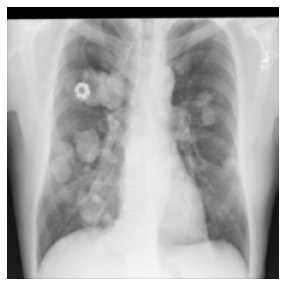

In [10]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
x_dec.show();

Grab the gradients using `Hook` and `HookBwd` and here we are grabbing them from the last layer `learn.model[0].model.layer4[-1]`

In [20]:
with HookBwd(learn.model[0].model.layer4[-1]) as hookg:
    with Hook(learn.model[0].model.layer4[-1]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0, cls].backward()
    grad = hookg.stored

Generate the heatmap

In [21]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

Check the shape of cam_map

In [22]:
cam_map.shape

torch.Size([8, 8])

In this case the heatmap is a 8 by 8 square. Note that the shape of cam_map is determined by the item_tfms shape set in the DataBlock. The larger the image used during training the larger the heat map.

We can view the heatmap using show_image

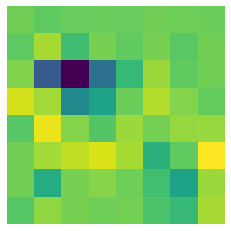

In [23]:
show_image(cam_map, figsize=(4,4));

The location on the heatmap that has the highest activations is the bright yellow square at position (8, 6).

We can view the heatmap on the image like so:

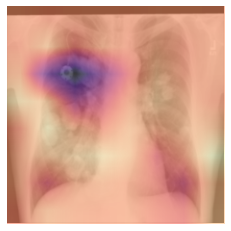

In [24]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0, x_dec.shape[1], x_dec.shape[2],0),
              interpolation='bilinear', cmap='magma');

### How do you generate the bounding boxes?

Now we need to be able to generate a bounding box around the area with the highest activation.

To do this we need to iterate over the cam_map values and get the indexes of the x and and y locations where the activations are the highest.

cam_map is a 8 by 8 `TensorDicom`

In [25]:
cam_map, cam_map.shape

(TensorDicom([[-8.4472e-04, -9.5445e-03, -4.9332e-03, -3.3654e-03, -5.2218e-03,
          -8.4908e-04, -1.5403e-03, -2.4963e-03],
         [-9.4932e-03,  2.4475e-02, -2.7448e-02,  3.7050e-03, -9.0903e-03,
           3.0944e-03, -1.2008e-02,  6.5261e-04],
         [ 8.2066e-03, -1.4966e-01, -2.3689e-01, -1.2372e-01, -3.4752e-02,
           1.9502e-02, -8.0750e-03,  3.3216e-04],
         [ 4.5416e-02,  2.2726e-02, -9.2590e-02, -6.1234e-02, -2.2953e-03,
           2.9902e-02,  9.6091e-03, -5.8895e-03],
         [-1.2964e-02,  5.5830e-02,  9.2314e-03, -1.5692e-02,  1.9809e-02,
           1.3701e-03,  1.7026e-02,  1.8781e-02],
         [ 9.4460e-04,  2.3095e-02,  3.6026e-02,  4.7414e-02,  2.4550e-02,
          -4.2417e-02, -9.2108e-03,  6.5061e-02],
         [ 1.5001e-04, -5.0004e-02,  2.9676e-03,  1.0669e-02, -1.0615e-03,
          -2.6506e-02, -6.1254e-02,  1.9756e-02],
         [-1.4906e-02,  1.5059e-02,  2.8116e-03, -2.1455e-03,  2.0732e-03,
          -1.9833e-02, -3.2341e-02,  2.5117e-

Convert the cam_map into a tensor but first we need to copy the tensor to host memory first by using `.cpu()`

In [26]:
arr = np.array(cam_map.cpu())
ten_map = tensor(arr)

Find the value of the tensor with the maximum value

In [27]:
ten_map.max()

tensor(0.0651)

Now to get the indexes of the maximum tensor we start by first finding the maximum value in each of the rows in `ten_map`

In [28]:
val = []
for i in range(0, ten_map.shape[0]):
    index, value = max(enumerate(ten_map[i]), key=operator.itemgetter(1))
    val.append(value)

In [29]:
val

[tensor(-0.0008),
 tensor(0.0245),
 tensor(0.0195),
 tensor(0.0454),
 tensor(0.0558),
 tensor(0.0651),
 tensor(0.0198),
 tensor(0.0251)]

We now have the maximum value of each row. Now to get the y_index and confirm that it matches the maximum value

In [30]:
y_index, y_value = max(enumerate(val), key=operator.itemgetter(1))
print(y_index, y_value)

5 tensor(0.0651)


The highest value of `0.1026` is found at index 4(remember that indexes start from 0 so index 4 is the 5th row)

Get the x_index

In [31]:
x_index, x_value = max(enumerate(ten_map[y_index]), key=operator.itemgetter(1))
x_index, x_value

(7, tensor(0.0651))

We can confirm that the highest value (0.1026) can be found at index [4,7]

Now we need to match that index to the image

To do this we need to know the shape of the image

In [32]:
imz = pydicom.dcmread(test_files[0]).pixel_array 
imz.shape

(1024, 1024)

And since the heatmap is broken down into 8 by 8 squares we need to divide the image into 8 by 8 sections so that they correspond to each section of the heatmap.  In this case the image is already a square but in reality it is not usually the case.

In [33]:
cms = cam_map.shape[0]
cms

8

Along the x-axis

In [34]:
x_ = imz.shape[1] // cms
x_

128

Along the y-axis

In [35]:
y_ = imz.shape[0] // cms
y_

128

So the image now has 8 by 8 squares each of size 128 by 128.

To match the square with highest activations we multiply the x and y indexes we calculated earlier to the size of each square

In [36]:
x = x_index * x_
x

896

In [37]:
y = y_index * y_
y

640

Using `TensorBBox` we can now plot a bounding box around the area of the image which has the highest activations

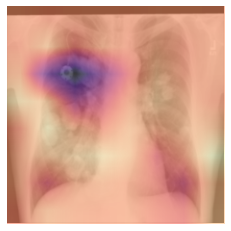

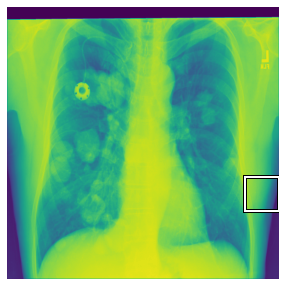

In [38]:
box = TensorBBox([x,y, (x + (imz.shape[0]//cms)),(y + (imz.shape[1]//cms))])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0, x_dec.shape[1], x_dec.shape[2],0),
              interpolation='bilinear', cmap='magma');
ctx = show_image(imz)
box.show(ctx=ctx);

### get_maps

`get_cmaps` is a handy `fmi` function from where you can easily view activation maps

first we have to define which layer in the model you want to view. For this case I want to view the last layer

In [39]:
layer = learn.model[0].model.layer4[-1]

get_cmaps allows for some flexibility:

- sanity = if you want to check actual values
- show_maps = display the class activation map
- show_cmap = display the test image with the class activation map super-imposed

No Pneumothorax
TensorBase([0, 1])
TensorBase([0.8646, 0.1354])


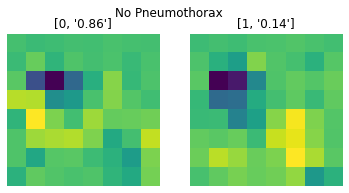

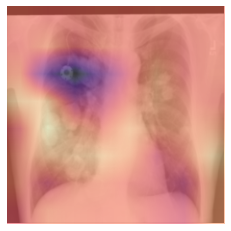

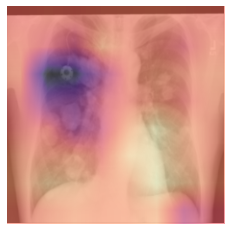

In [40]:
get_cmaps(test_one, dls, learn, layer=layer, sanity=True, show_maps=True, show_cmap=True)

The predicted class for this image is `Pneumothorax` which is tensor 1 with a probability of `0.58`.

`get_cmaps` displays the activation maps of each class (predicted first) and also displays the image with super imposed activation maps

### get_boxes

`get_boxes` creates bounding boxes at locations with the highest activations in each class activation map.

It also includes code updates to `TensorBBox` and `LabelledBBox` classes so that you can change the color of the bounding boxes

[array([128, 512, 256, 640]), array([640, 768, 768, 896])]

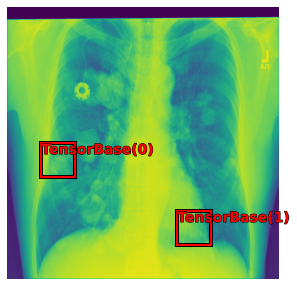

In [42]:
get_boxes(test_one, dls, learn, layer=layer, sanity=False , show_maps=False, show_img=True, color='red')